# Manifold analysis example with VGG16

This notebook contains a short example for running an analysis on a PyTorch model. We will use VGG16 trained on CIFAR-100 dataset as an example. For this type of analysis, we should use a dataset with a large number of classes, roughly `num_classes>30`.

First, some generic imports

In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
import torch
from torchvision import datasets, transforms, models

We'll also need to import the `manifold_analysis_corr` function which implements the analysis technique. In addition, we'll also import some helper functions for creating the appropriate input datasets (`make_manifold_data`) and extracting model activations (`extractor`).

In [2]:
from mftma.manifold_analysis_correlation import manifold_analysis_corr
from mftma.utils.make_manifold_data import make_manifold_data
from mftma.utils.activation_extractor import extractor
from mftma.utils.analyze_pytorch import analyze

## Training a model

We also need a model and a dataset, so we'll quickly train an insance of VGG16 on CIFAR-100 for a few epochs.

First, create the datasets and dataloaders

In [3]:
mean = (0.5070751592371323, 0.48654887331495095, 0.4409178433670343)
std = (0.2673342858792401, 0.2564384629170883, 0.27615047132568404)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

train_dataset = datasets.CIFAR100('../data', train=True, download=True,
                   transform=transform_train)
test_dataset = datasets.CIFAR100('../data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize(mean, std)
                   ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


Training and testing functions

In [4]:
def train(model, device, train_loader, optimizer):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        output = torch.nn.functional.log_softmax(output, dim=1)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            output = torch.nn.functional.log_softmax(output, dim=1)
            test_loss += torch.nn.functional.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set epoch {}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        epoch, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

Now, let's train the model for a few epochs. As this is just an example, we don't care about making the best performing model we can here. It is easy to make a much better model if you want.

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.vgg16(num_classes=100)
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
for i in range(20):
    train(model, device, train_loader, optimizer)
    test(model, device, test_loader, i)


Test set epoch 0: Average loss: 4.3674, Accuracy: 362/10000 (4%)


Test set epoch 1: Average loss: 3.9780, Accuracy: 651/10000 (7%)


Test set epoch 2: Average loss: 3.8999, Accuracy: 935/10000 (9%)


Test set epoch 3: Average loss: 3.6757, Accuracy: 1257/10000 (13%)


Test set epoch 4: Average loss: 3.5685, Accuracy: 1351/10000 (14%)


Test set epoch 5: Average loss: 3.3221, Accuracy: 1893/10000 (19%)


Test set epoch 6: Average loss: 3.1883, Accuracy: 2167/10000 (22%)


Test set epoch 7: Average loss: 3.1638, Accuracy: 2270/10000 (23%)


Test set epoch 8: Average loss: 3.0099, Accuracy: 2541/10000 (25%)


Test set epoch 9: Average loss: 2.8608, Accuracy: 2879/10000 (29%)


Test set epoch 10: Average loss: 2.8256, Accuracy: 2914/10000 (29%)


Test set epoch 11: Average loss: 2.7660, Accuracy: 3052/10000 (31%)


Test set epoch 12: Average loss: 2.6354, Accuracy: 3349/10000 (33%)


Test set epoch 13: Average loss: 2.5792, Accuracy: 3427/10000 (34%)


Test set epoch 14: Average loss: 2.

## Set the model to eval mode

In [6]:
model = model.eval()

## Create the manifold dataset

To create this, we have to specify the number of classes we want to sample, which in this case will just be the total number of samples in the dataset, so `sampled_classes=100`. We also need to decide how many examples per class we want to use, and in this case we will use `examples_per_class=50`. Note that using large numbers of examples will result in a much longer runtime. We will also create the manifold data from the train dataset, and show the test dataset later.

In [7]:
sampled_classes = 100
examples_per_class = 50

data = make_manifold_data(train_dataset, sampled_classes, examples_per_class, seed=0)
data = [d.to(device) for d in data]

## Extract activations from the model

Now we need to extract the activations at each layer of the model when the manifold data is given as an input. We can use the extractor given in `mftma.utils.activation_extractor`, which *usually* works, though depending on how the specific model is implemented, might miss some layers. If you do use it, make sure that all the layers you want to analyze are found!  For this example, we will only look at the `Conv2D` and `Linear` layers of VGG16.

In [8]:
activations = extractor(model, data, layer_types=['Conv2d', 'Linear'])
list(activations.keys())

['layer_0_Input',
 'layer_1_Conv2d',
 'layer_3_Conv2d',
 'layer_6_Conv2d',
 'layer_8_Conv2d',
 'layer_11_Conv2d',
 'layer_13_Conv2d',
 'layer_15_Conv2d',
 'layer_18_Conv2d',
 'layer_20_Conv2d',
 'layer_22_Conv2d',
 'layer_25_Conv2d',
 'layer_27_Conv2d',
 'layer_29_Conv2d',
 'layer_33_Linear',
 'layer_36_Linear',
 'layer_39_Linear']

## Prepare activations for analysis

Now we're almost ready to run the analysis on the extracted activations. The final step is to convert them into the correct shape and pass them to `manifold_analysis_corr`. For example, the shape of the activations in `layer_1_Conv2d` is `(50, 64, 32, 32)`, which we will flatten to `(50, 65536)` and transpose to the `(65536, 50)` format the analysis expects.  This flattening may not always be appropriate as one might want to analyze each spatial location (or each timestep of a sequence model) independently.

Additionally, the number of features here is quite a bit larger than needed, so we'll also do a random projection to `5000` dimensions to save time and memory usage. This step is optional and shouldn't change the geometry too much (see the Johnson–Lindenstrauss lemma) but it is useful to save on computation.

In [9]:
for layer, data, in activations.items():
    X = [d.reshape(d.shape[0], -1).T for d in data]
    # Get the number of features in the flattened data
    N = X[0].shape[0]
    # If N is greater than 5000, do the random projection to 5000 features
    if N > 5000:
        print("Projecting {}".format(layer))
        M = np.random.randn(5000, N)
        M /= np.sqrt(np.sum(M*M, axis=1, keepdims=True))
        X = [np.matmul(M, d) for d in X]
    activations[layer] = X

Projecting layer_1_Conv2d
Projecting layer_3_Conv2d
Projecting layer_6_Conv2d
Projecting layer_8_Conv2d
Projecting layer_11_Conv2d
Projecting layer_13_Conv2d
Projecting layer_15_Conv2d
Projecting layer_18_Conv2d
Projecting layer_20_Conv2d
Projecting layer_22_Conv2d


## Run the analysis on the prepped activations

And store the results for later plotting

In [10]:
capacities = []
radii = []
dimensions = []
correlations = []

for k, X, in activations.items():
    # Analyze each layer's activations
    a, r, d, r0, K = manifold_analysis_corr(X, 0, 300, n_reps=1)
    
    # Compute the mean values
    a = 1/np.mean(1/a)
    r = np.mean(r)
    d = np.mean(d)
    print("{} capacity: {:4f}, radius {:4f}, dimension {:4f}, correlation {:4f}".format(k, a, r, d, r0))
    
    # Store for later
    capacities.append(a)
    radii.append(r)
    dimensions.append(d)
    correlations.append(r0)

layer_0_Input capacity: 0.039891, radius 1.561030, dimension 34.938634, correlation 0.332916
layer_1_Conv2d capacity: 0.040001, radius 1.547228, dimension 35.105979, correlation 0.286376
layer_3_Conv2d capacity: 0.041311, radius 1.504518, dimension 34.452234, correlation 0.271564
layer_6_Conv2d capacity: 0.042857, radius 1.467209, dimension 33.758073, correlation 0.281075
layer_8_Conv2d capacity: 0.043739, radius 1.451202, dimension 33.340560, correlation 0.387337
layer_11_Conv2d capacity: 0.045510, radius 1.441094, dimension 32.190691, correlation 0.379990
layer_13_Conv2d capacity: 0.047295, radius 1.417841, dimension 31.239246, correlation 0.362747
layer_15_Conv2d capacity: 0.048861, radius 1.390841, dimension 30.653582, correlation 0.392245
layer_18_Conv2d capacity: 0.054140, radius 1.348109, dimension 28.102692, correlation 0.323475
layer_20_Conv2d capacity: 0.059747, radius 1.302653, dimension 25.881835, correlation 0.430380
layer_22_Conv2d capacity: 0.065559, radius 1.273996, dim

## Plot the results

Here we will plot the results of the analysis we just ran. Note that we won't plot the results of the final linear layer as this is the model output after classification has already occured.

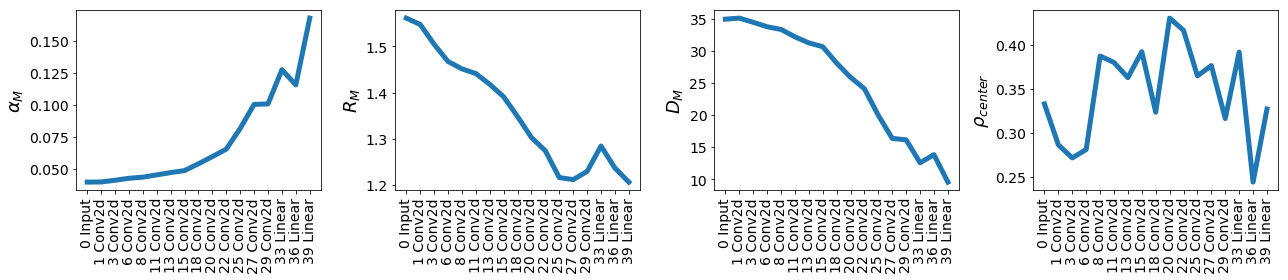

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(18, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(activations.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()

## Combined analysis

The above steps are also bundled together in the `analyze` function in `utils.analyze_pytorch`. This works for some use cases, but more complex analyses may require more control. Here, we will demonstrate this on the CIFAR-100 test dataset.

In [12]:
sampled_classes = 100
examples_per_class = 50
layer_types = ['Input', 'Conv2d', 'Linear']
projection = True
projection_dimension = 5000
seed = 0

model = model.eval()
results = analyze(model, test_dataset, 
                  sampled_classes=sampled_classes, 
                  examples_per_class=examples_per_class, 
                  layer_types=layer_types,
                  projection=projection, 
                  projection_dimension=projection_dimension,
                  seed=seed)

Analyzing layer_0_Input
Analyzing layer_1_Conv2d
Analyzing layer_3_Conv2d
Analyzing layer_6_Conv2d
Analyzing layer_8_Conv2d
Analyzing layer_11_Conv2d
Analyzing layer_13_Conv2d
Analyzing layer_15_Conv2d
Analyzing layer_18_Conv2d
Analyzing layer_20_Conv2d
Analyzing layer_22_Conv2d
Analyzing layer_25_Conv2d
Analyzing layer_27_Conv2d
Analyzing layer_29_Conv2d
Analyzing layer_33_Linear
Analyzing layer_36_Linear
Analyzing layer_39_Linear


Plot the results

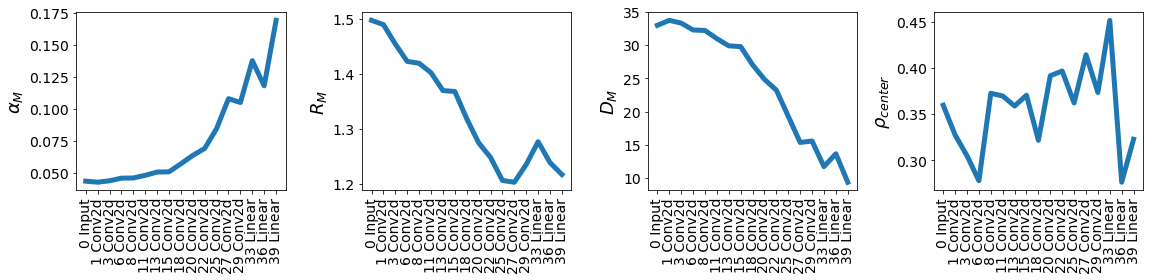

In [13]:
capacities = []
radii = []
dimensions = []
correlations = []
for layer, result in results.items():
        a = 1/np.mean(1/result['capacity'])
        r = np.mean(result['radius'])
        d = np.mean(result['dimension'])
        
        capacities.append(a)
        radii.append(r)
        dimensions.append(d)
        correlations.append(result['correlation'])

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

axes[0].plot(capacities, linewidth=5)
axes[1].plot(radii, linewidth=5)
axes[2].plot(dimensions, linewidth=5)
axes[3].plot(correlations, linewidth=5)

axes[0].set_ylabel(r'$\alpha_M$', fontsize=18)
axes[1].set_ylabel(r'$R_M$', fontsize=18)
axes[2].set_ylabel(r'$D_M$', fontsize=18)
axes[3].set_ylabel(r'$\rho_{center}$', fontsize=18)

names = list(results.keys())
names = [n.split('_')[1] + ' ' + n.split('_')[2] for n in names]
for ax in axes:
    ax.set_xticks([i for i, _ in enumerate(names)])
    ax.set_xticklabels(names, rotation=90, fontsize=16)
    ax.tick_params(axis='both', which='major', labelsize=14)

plt.tight_layout()
plt.show()